In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Part   1  ‐ Exploratory   data   analysis 
The   attached   l   ogins.json     file   contains   (simulated)   timestamps   of   user   logins   in   a   particular 
geographic   location.   Aggregate   these   login   counts   based   on   15­ minute   time   intervals,   and 
visualize   and   describe   the   resulting   time   series   of   login   counts   in   ways   that   best   characterize   the 
underlying   patterns   of   the   demand.   Please   report/illustrate   important   features   of   the   demand, 
such   as   daily   cycles.   If   there   are   data   quality   issues,   please   report   them.

### Import data

In [3]:
# load json as string
# json.load((open('./logins.json')))
logins_df = pd.read_json('./logins.json')

In [4]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [5]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


### Aggregate data every 15 minutes

In [7]:
# Set time stamps as index
logins_df.index = logins_df.login_time
# Aggregate time every 15 minutes
login_agg = logins_df.resample('15min').count()
login_agg.columns = ['15_min_count']
print(login_agg.head())
# Aggregation sum must be equal to len of original data frame
login_agg['15_min_count'].sum() == len(logins_df)

                     15_min_count
login_time                       
1970-01-01 20:00:00             2
1970-01-01 20:15:00             6
1970-01-01 20:30:00             9
1970-01-01 20:45:00             7
1970-01-01 21:00:00             1


True

### Plot data

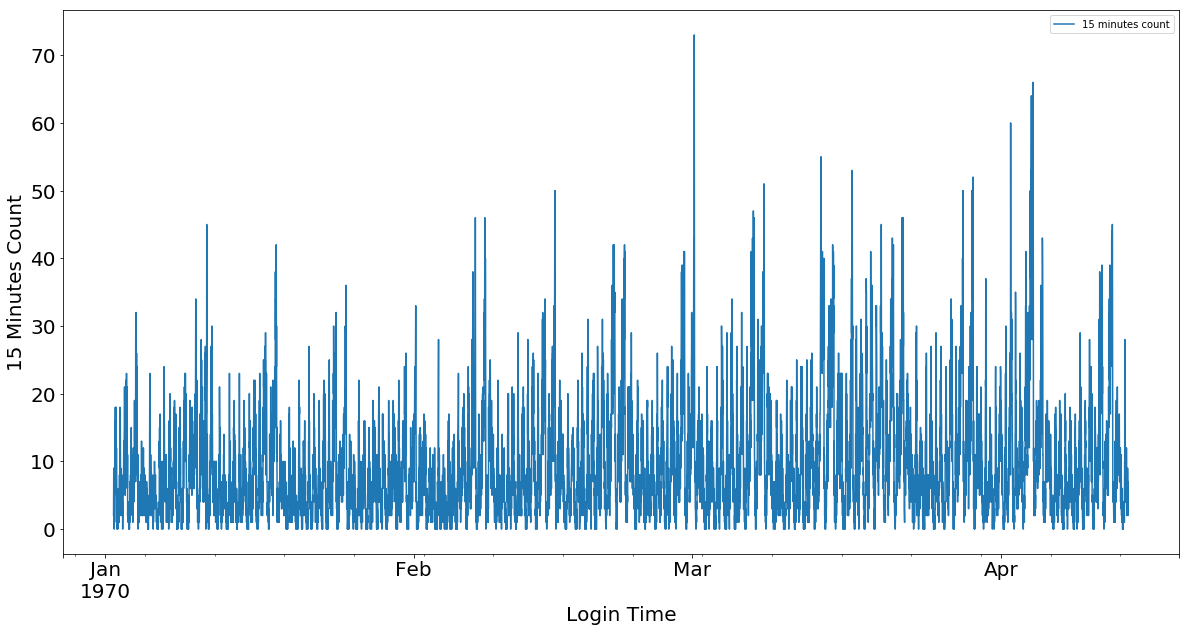

In [50]:
fig = login_agg.plot(figsize=(20, 10), fontsize=20)
fig.legend(["15 minutes count"])
_ = plt.xlabel("Login Time", size=20)
_ = plt.ylabel("15 Minutes Count", size=20)
_ = plt.show()

The data is to dense, it needs to be resampled to properly visually identify any parterns. Maybe it would be helpful to resample the data daily and plotting the total logins per day.

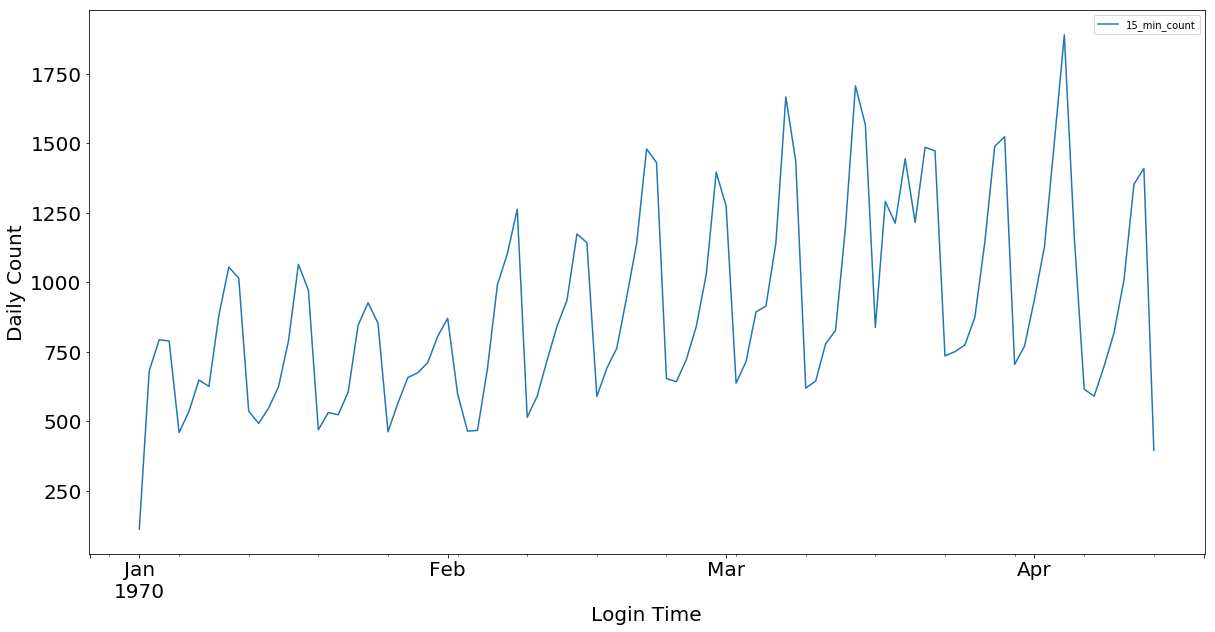

In [61]:
hourly = login_agg.resample("D").sum()
_ = hourly.plot(figsize=(20, 10), fontsize=20)
_ = plt.xlabel("Login Time", size=20)
_ = plt.ylabel("Daily Count", size=20)
_ = plt.show()

The dayly plot shows that activity tends to increase at the end of each week without exception and that it drastically drops the following week to increase again. The exception to this rule is the third week of March 1970 where most of the daily counts are relatively high.

Let's now see what happens daily by resampling the data hourly and choosing a random week.

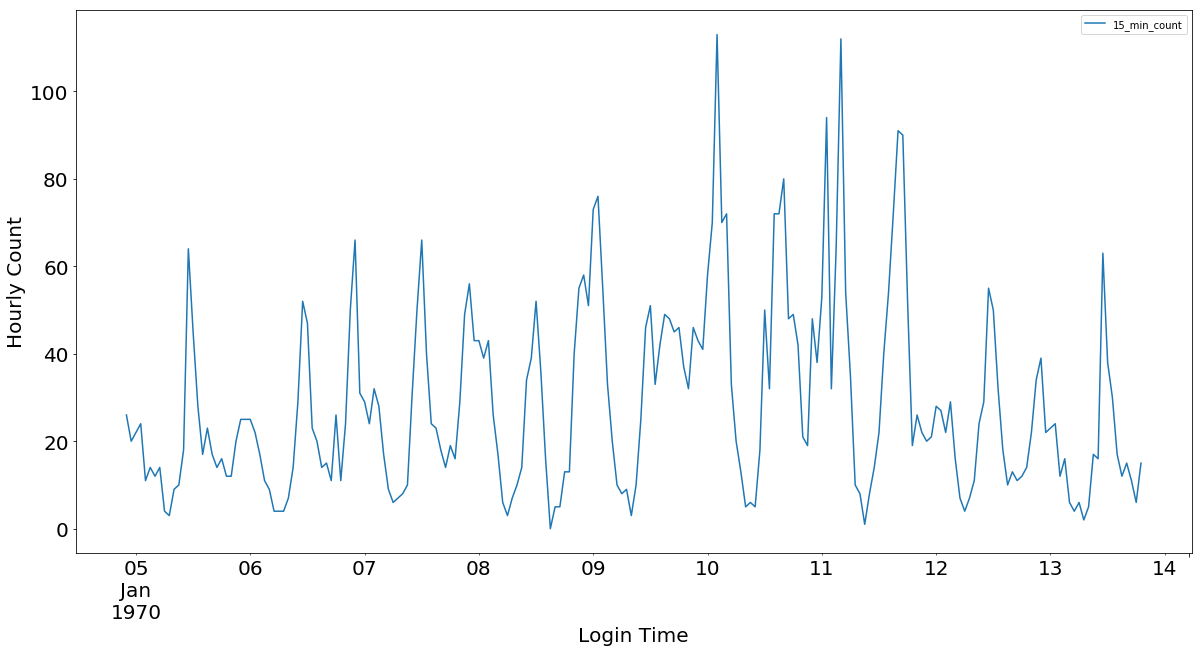

In [65]:
hourly = login_agg.resample("H").sum()
_ = hourly[74:288].plot(figsize=(20, 10), fontsize=20)
_ = plt.xlabel("Login Time", size=20)
_ = plt.ylabel("Hourly Count", size=20)
_ = plt.show()

Daily aggregation shows that daily there are picks of demand at noon and midnight and that most of the demand is during the weekends.

# Part   2  ‐ Experiment   and   metrics   design 
The   neighboring   cities   of   Gotham   and   Metropolis   have   complementary   circadian   rhythms:   on 
weekdays,   Ultimate   Gotham   is   most   active   at   night,   and   Ultimate   Metropolis   is   most   active 
during   the   day.   On   weekends,   there   is   reasonable   activity   in   both   cities. 
 
However,   a   toll   bridge,   with   a   two way   toll,   between   the   two   cities   causes   driver   partners   to   tend 
to   be   exclusive   to   each   city.   The   Ultimate   managers   of   city   operations   for   the   two   cities   have 
proposed   an   experiment   to   encourage   driver   partners   to   be   available   in   both   cities,   by 
reimbursing   all   toll   costs. 

**1. What   would   you   choose   as   the   key   measure   of   success   of   this   experiment   in 
encouraging   driver   partners   to   serve   both   cities,   and   why   would   you   choose   this   metric?**
For this experiment I would choose as a key measure of success the average number of times the toll bridge is being used by driver. An increase in that number will mean that reimbursing the toll cost is good initiative to encourage drivers to work between cities. However, we need to take into account the complementary circadian rythms of both cities. So, when calculating the averages, I will calculate an average for weekdays and another one for weekends.

**2. Describe   a   practical   experiment   you   would   design   to   compare   the   effectiveness   of   the proposed   change   in   relation   to   the   key   measure   of   success.   Please   provide   details   on:**  
**a. how   you   will   implement   the   experiment**
I will divide randomly the drivers population in two, A and B. For froup A the toll costs will be reimbursed (this the change the company wants to introduce), and for group B nothing will be reinbursed. Then for each user of each group I will record the number of times the toll bridge is used. As mentioned before, weekdays will be recorded separately from weekends. 

**b. what   statistical   test(s)   you   will   conduct   to   verify   the   significance   of   the 
observation**
The experiment corresponds to an AB test. For each population we are interested in the average number of times the toll bridge was used per day. So if there is a difference between the average of both populations, we want to determine if that difference is statistically significant. For this purpose I will implement a z-test where I will evaluate the statistical significance of the difference in average between both populations.

Given the difference in behavior between weekdays and weekends, I will perform the test for weekdays and weekends separately.

**c. how   you   would   interpret   the   results   and   provide   recommendations   to   the   city 
operations   team   along   with   any   caveats.**
If a statisticall significant increase in the toll bridge usage is observed, I will recommend the city operations team to go with the changes. However, as mentioned before I will determine first if there is a difference between weekdays and weekends. If there is, that information will be provided too so the toll costs are reimboursed only when the bridge is used the appropriate days. For example it may make sense to reimburse the costs during the weekends but not during weekdays. Having saying this, it may also be useful when analyzing the data to conduct the statistical test by the hour to determine if the toll bridge usage is also time dependent particularly in weekdays.


# Part   3  ‐ Predictive   modeling 
 
Ultimate   is   interested   in   predicting   rider   retention.   To   help   explore   this   question,   we   have 
provided   a   sample   dataset   of   a   cohort   of   users   who   signed   up   for   an   Ultimate   account   in January   2014.   The   data   was   pulled   several   months   later;   we   consider   a   user   retained   if   they 
were   “active”   (i.e.   took   a   trip)   in   the   preceding   30   days. 
 
We   would   like   you   to   use   this   data   set   to   help   understand   what   factors   are   the   best   predictors 
for   retention,   and   offer   suggestions   to   operationalize   those   insights   to   help   Ultimate. 
 
The   data   is   in   the   attached   file   ultimate_data_challenge.json.   See   below   for   a   detailed 
description   of   the   dataset.   Please   include   any   code   you   wrote   for   the   analysis   and   delete   the 
dataset   when   you   have   finished   with   the   challenge.

### Data   description 
● **city**:     city   this   user   signed   up   in 

● **phone**:     primary   device   for   this   user

● **signup_date**:     date   of   account   registration;   in   the   form   ‘YYYY MM DD’

● **last_trip_date**:     the   last   time   this   user   completed   a   trip;   in   the   form   ‘YYYY MM DD’ 

● **avg_dist**:     the   average   distance   in   miles   per   trip   taken   in   the   first   30   days   after   signup

● **avg_rating_by_driver**:     the   rider’s   average   rating   over   all   of   their   trips

● **avg_rating_of_driver**:   the   rider’s   average   rating   of   their   drivers   over   all   of   their   trips 

● **surge_pct**:     the   percent   of   trips   taken   with   surge   multiplier   >   1 

● **avg_surge**:   The   average   surge   multiplier   over   all   of   this   user’s   trips 
  
● **trips_in_first_30_days**:   the   number   of   trips   this   user   took   in   the   first   30   days after 
signing   up

● **ultimate_black_user**:   TRUE   if   the   user   took   an   Ultimate   Black   in   their   first   30   days; 
FALSE   otherwise 

● **weekday_pct**:     the   percent   of   the   user’s   trips   occurring   during   a   weekday 

**1. Perform   any   cleaning,   exploratory   analysis,   and/or   visualizations   to   use   the   provided 
data   for   this   analysis   (a   few   sentences/plots   describing   your   approach   will   suffice).   What 
fraction   of   the   observed   users   were   retained?**

avg_rating_by_driver', 'avg_rating_of_driver' and 'phone' have null values. However the rows containing those null fields may still contain usefull information. The average value for the ratings tends to be very good, so for 'avg_rating_by_driver' and 'avg_rating_of_driver' the null values are changed their mean values which are 4.78 and 4.608 respectively. For the 'phone' collumns, the null values will be replaced by the string 'other'.

The column 'ultimate_black_user' is converted from boolean to int. 'last_trip_date' and 'signup_date' are turned to datetime type. Finally a column registering the number of days between the last trip and the registration day is added.

An inspection of the pairwise correlations bewteen numerical collumns doesn't show a strong correlation between variables. The strongest correlation is bewteen 'avg_surge' and 'surge_pct' with a value of 0.79. This indicates that practically all the columns can be considered as independent variables for future analisys.

To calculate the fraction of retained users, given that the exact date where the data was retrieved is not provided, the most recent date in the column 'last_trip_date' is considered as the reference to estimate user retention. Retained users are those who have completed a trip in the preceding 30 days with respect to the reference date. Then, up to the most recent trip date in the data set, the fraction of retained users is 37.61%.

**2. Build   a   predictive   model   to   help   Ultimate   determine   whether   or   not   a   user   will   be   active 
in   their   6th   month   on   the   system.   Discuss   why   you   chose   your   approach,   what 
alternatives   you   considered,   and   any   concerns   you   have.   How   valid   is   your   model? 
Include   any   key   indicators   of   model   performance.**

Below is the matrix correlation plots.  

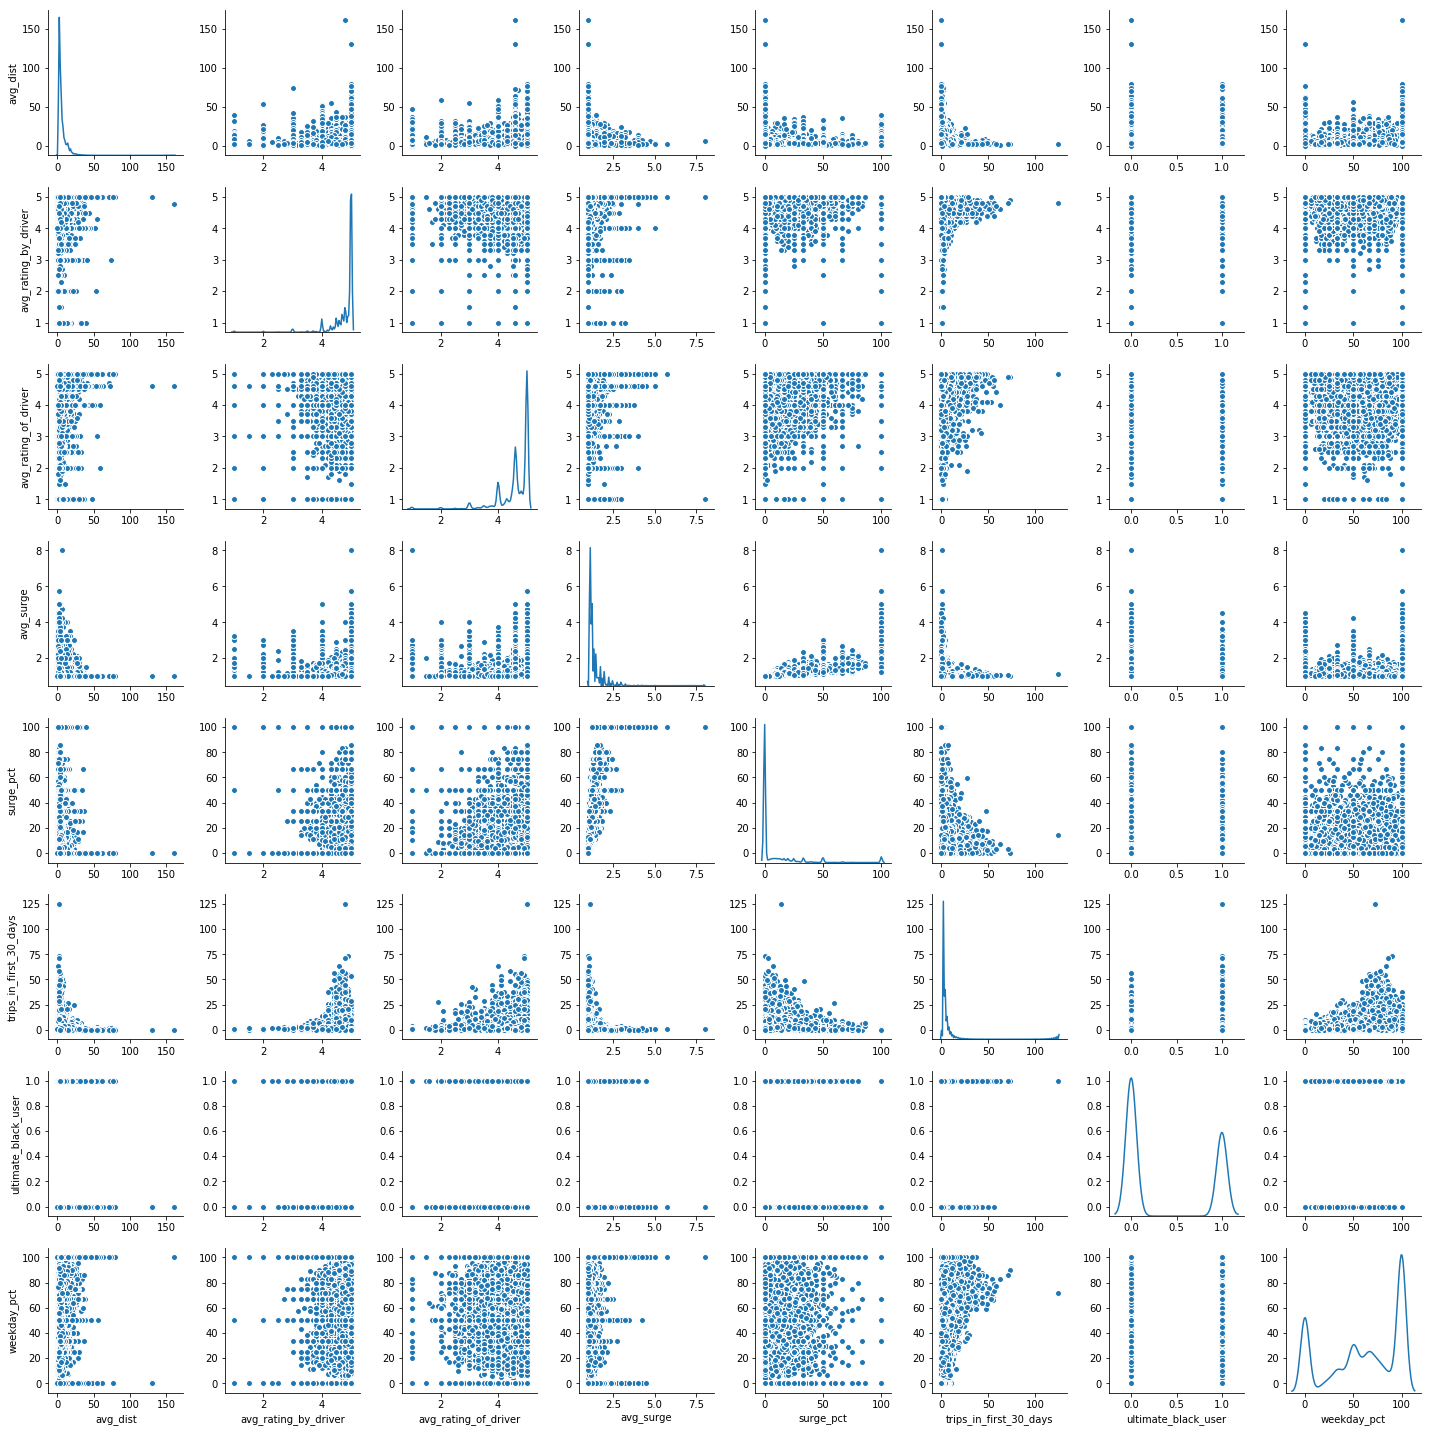

The diagonal is the distribution of values for each variable. It shows that most of the variables values are squeezed in one direction. When we train the models, this may make the models to underperform, so it will be better to express rescale the variables which are squeezed and cover a long range of values. So, the percentages are divided by 100 to express them between 0 and 1. The natural logarithm is taken for 'avg_dist', and the 'trips_in_first_30_days' is divided by its maximum value.

**3. Briefly   discuss   how   Ultimate   might   leverage   the   insights   gained   from   the   model   to 
improve   its   long­ term   rider   retention   (again,   a   few   sentences   will   suffice).**

# Code

**1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?**

In [273]:
# ultimate_df = pd.read_json('./ultimate_data_challenge.json')%%!
df = pd.DataFrame(json.load((open('./ultimate_data_challenge.json'))))
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [274]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


'avg_rating_by_driver', 'avg_rating_of_driver' and 'phone' have null values. However the rows containing those null fields may still contain usefull information. The average value for the ratings tends to be very good, so for 'avg_rating_by_driver' and 'avg_rating_of_driver' the null values are changed their mean values which are 4.78 and 4.608 respectively. For the 'phone' collumns, the null values will be replaced by the string 'other'. 

The column 'ultimate_black_user' is converted from boolean to int. 'last_trip_date' and  'signup_date' are turned to datetime type. Finally a column registering the number of days between the last trip and the registration day is added.

In [315]:
# Copy df to start modifying data set
data = df.copy(deep=True)

# Fill null values
data.avg_rating_by_driver.fillna(data.avg_rating_by_driver.mean(), inplace=True)
data.avg_rating_of_driver.fillna(data.avg_rating_of_driver.mean(), inplace=True)
data.phone.fillna('other', inplace=True)

# Change boolean to int
data.ultimate_black_user = data.ultimate_black_user.astype(int)

# Turn time columns to datetime format
data.last_trip_date = pd.to_datetime(data.last_trip_date, infer_datetime_format=True)
data.signup_date = pd.to_datetime(data.signup_date, infer_datetime_format=True)

# Add column for number of days between last_trip_date and signup_date
data['last_to_sign'] = data.last_trip_date - data.signup_date

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
last_to_sign              50000 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(6), int64(2), object(2), timedelta64[ns](1)
memory usage: 5.0+ MB


#### Display correlation matrix bewteen numerical variables.

In [316]:
data.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,1.000000,0.079793,0.028508,-0.081491,-0.104414,-0.136329,0.032310,0.101652
avg_rating_by_driver,0.079793,1.000000,0.101660,0.010498,0.019964,-0.039097,0.009328,0.020366
avg_rating_of_driver,0.028508,0.101660,1.000000,-0.021653,-0.003290,-0.011060,-0.001916,0.012587
avg_surge,-0.081491,0.010498,-0.021653,1.000000,0.793582,-0.001841,-0.078791,-0.110071
surge_pct,-0.104414,0.019964,-0.003290,0.793582,1.000000,0.005720,-0.106861,-0.144918
trips_in_first_30_days,-0.136329,-0.039097,-0.011060,-0.001841,0.005720,1.000000,0.112210,0.050388
ultimate_black_user,0.032310,0.009328,-0.001916,-0.078791,-0.106861,0.112210,1.000000,0.035998
weekday_pct,0.101652,0.020366,0.012587,-0.110071,-0.144918,0.050388,0.035998,1.000000


An inspection of the pairwise correlations bewteen numerical collumns doesn't show a strong correlation between variables. The strongest correlation is bewteen 'avg_surge' and 'surge_pct' with a value of 0.79. This indicates that practically all the columns can be considered as independent variables for future analisys.

To calculate the fraction of retained users, given that the exact date where the data was retrieved is not provided, the most recent date in the column 'last_trip_date' is considered as the reference to estimate user retention. Retained users are those who have completed a trip in the preceding 30 days with respect to the reference date.

In [317]:
ref_date = data.last_trip_date.max()
# Fraction of retained users
fraction = np.sum(( ref_date - data.last_trip_date) <= '30 days') / len(data) * 100
print("Fraction of retained users: %0.2f%%"%(fraction))

Fraction of retained users: 37.61%


**2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.**

Pariwise correlation plot.

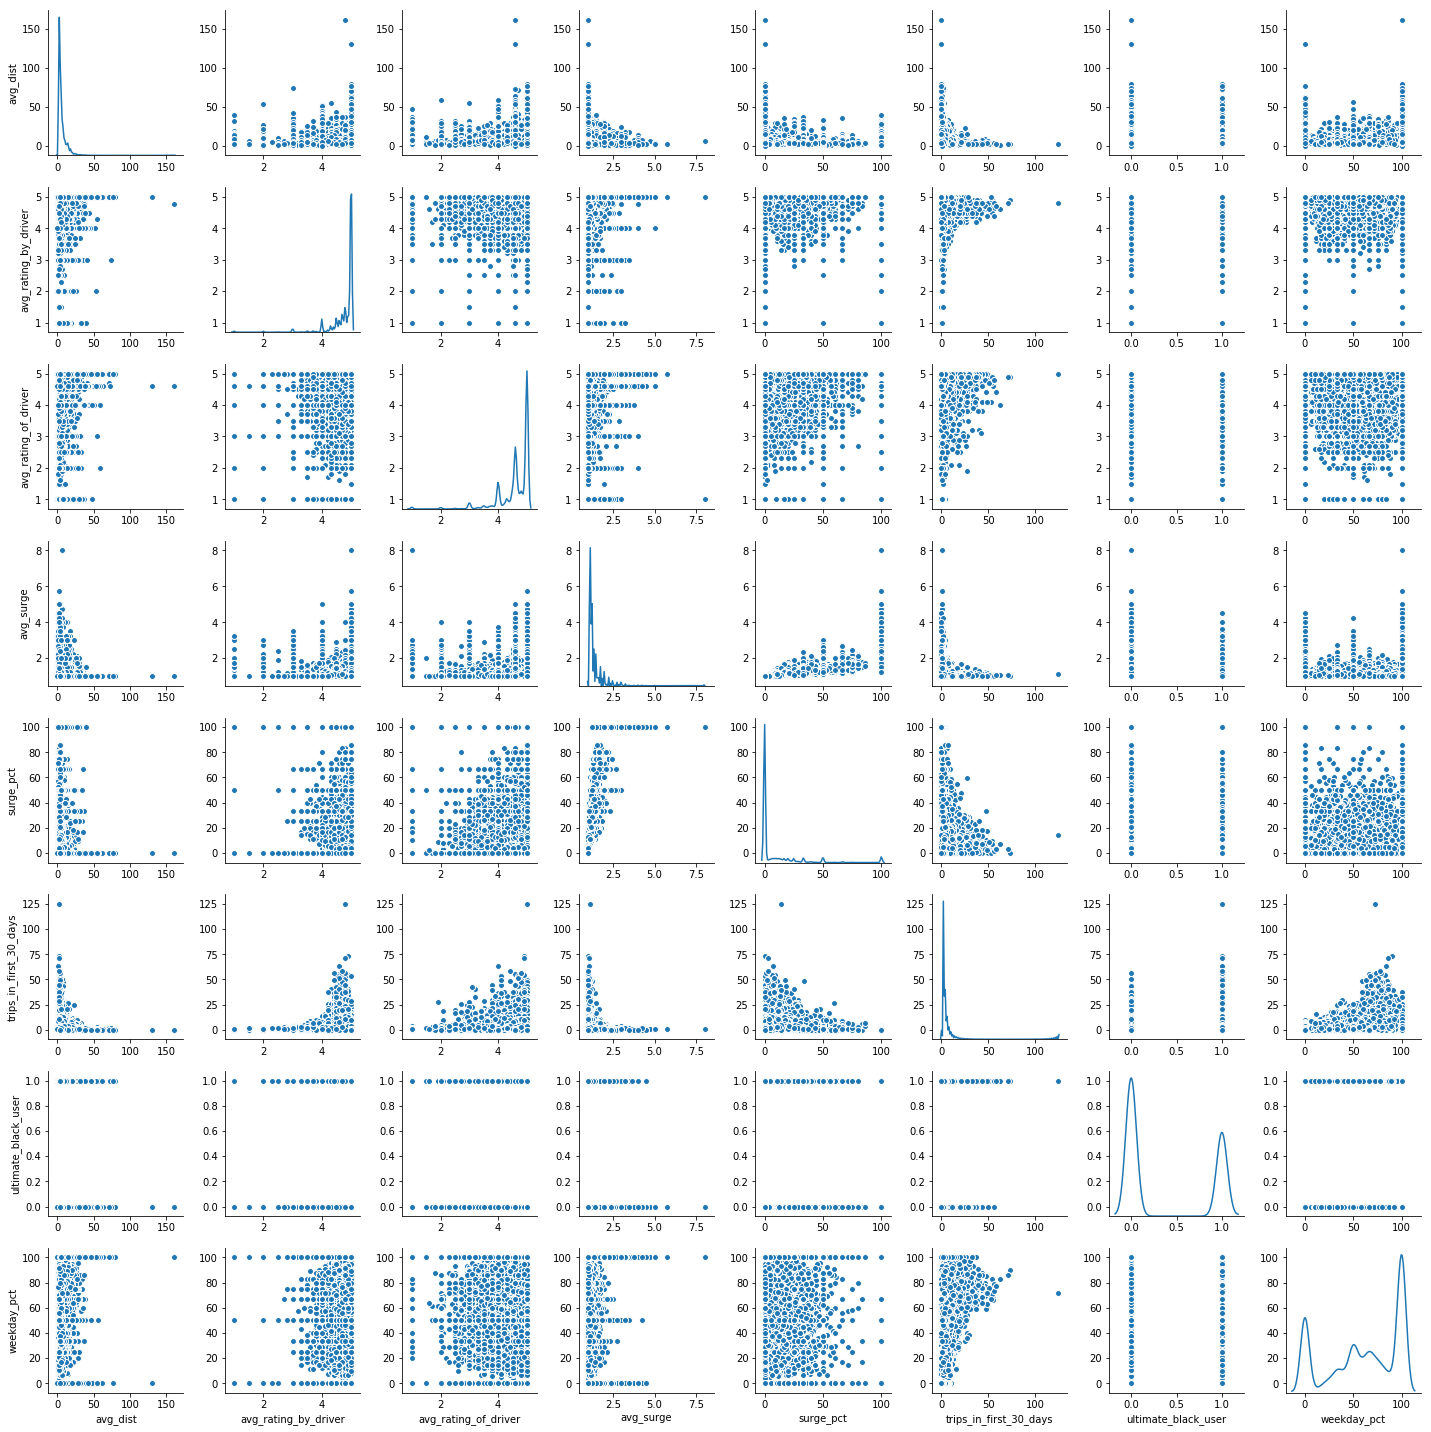

In [280]:
sns.pairplot(data, diag_kind="kde")
plt.show()

The diagonal is the distribution of values for each variable. It shows that most of the variables values are squeezed in one direction. When we train the models, this may make the models to underperform, so it will be better to express rescale the variables which are squeezed and cover a long range of values. So, the percentages are divided by 100 to express them between 0 and 1. The natural logarithm is taken for 'avg_dist', and the 'trips_in_first_30_days' is divided by its maximum value.

In [318]:
data.avg_dist = np.log(data.avg_dist + 0.001) # + 0.001 to avoid having log of zero
data.trips_in_first_30_days = data.trips_in_first_30_days / data.trips_in_first_30_days.max()
data.surge_pct = data.surge_pct / 100
data.weekday_pct = data.weekday_pct / 100

** Using one-hot encoding for categorical columns**

In [324]:
model_data = pd.get_dummies(data)
model_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,last_to_sign,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,1.300464,5.0,4.7,1.10,2014-06-17,2014-01-25,0.154,0.032,1,0.462,143 days,0,1,0,0,1,0
1,2.111546,5.0,5.0,1.00,2014-05-05,2014-01-29,0.000,0.000,0,0.500,96 days,1,0,0,1,0,0
2,-0.260067,5.0,4.3,1.00,2014-01-07,2014-01-06,0.000,0.024,0,1.000,1 days,1,0,0,0,1,0
3,0.859085,4.9,4.6,1.14,2014-06-29,2014-01-10,0.200,0.072,1,0.800,170 days,0,1,0,0,1,0
4,1.141352,4.9,4.4,1.19,2014-03-15,2014-01-27,0.118,0.112,0,0.824,47 days,0,0,1,1,0,0
